1. Import required libraries

In [ ]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.activation import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

2. Define loss variables

In [ ]:
global d_loss_arr, g_loss_arr
d_loss_arr = []
g_loss_arr = []

3. Build generator

In [ ]:
def generator_b():
  # irow = 28
  # icol = 28
  # ichannels = 1
  # img_shape = (irow, icol, ichannels)
  noise_shape = (100,)
  model = Sequential()
  #layers -> Dense->LeakyReLU->BatchNorm->Dense->LeakyReLU->BatchNorm->Dense->LeakyReLU->BatchNorm->Dense
  model.add(Dense(256, input_shape = noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum = 0.8))

  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum = 0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum = 0.8))

  model.add(Dense(np.prod(img_shape),activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape = noise_shape)
  img = model(noise)

  return Model(noise, img)



4. Build Discriminator

In [ ]:
def discriminator_b():
  # irow = 28
  # icol = 28
  # ichannels = 1
  img_shape = (irow, icol, ichannels)
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))

  model.summary()
  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

4. Train the model

In [ ]:
def train_model(epochs, batch_size = 128, save_interval = 500):
  (X_train, _),(_, _) = mnist.load_data()
  X_train = (X_train.astype(np.float32)-127.5)/127.5
  X_train = np.expand_dims(X_train, axis = 3)
  half_batch = int(batch_size/2)

  for epoch in range(epochs):
    #training discriminator
    index = np.random.randint(0, X_train.shape[0],half_batch)
    imgs = X_train[index]
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #train generator
    noise = np.random.normal(0, 1,(batch_size, 100))
    valid_y = np.array([1]*batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)

    print('%d [D loss: %f, acc.:%.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch%save_interval == 0:
      save_imgs(epoch)
    g_loss_arr.append(g_loss)
    d_loss_arr.append(d_loss[0])
    # return loss




5. Save images

In [ ]:
def save_imgs(epochs):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)
  gen_imgs = 0.5*gen_imgs + 0.5
  fig, axis = plt.subplots(r, c)
  count = 0
  for i in range(r):
    for j in range(c):
      axis[i, j].imshow(gen_imgs[count,:,:,0], cmap = 'gray')
      axis[i, j].axis('off')
      count += 1
  fig.savefig('mnist_%d'%epochs)
  plt.close()


6. Main function

In [ ]:
optimizer = Adam(0.0002, 0.5)

irow = 28
icol = 28
ichannels = 1
img_shape = (irow, icol, ichannels)

discriminator = discriminator_b()
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

generator = generator_b()
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

z = Input(shape = (100,))
img = generator(z)
loss = []
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)
train_model(epochs = 5, batch_size = 32, save_interval = 20)
# print(loss[0][0], loss[1], '++')
print(d_loss_arr, g_loss_arr)
generator.save('gen_model_test.h5')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

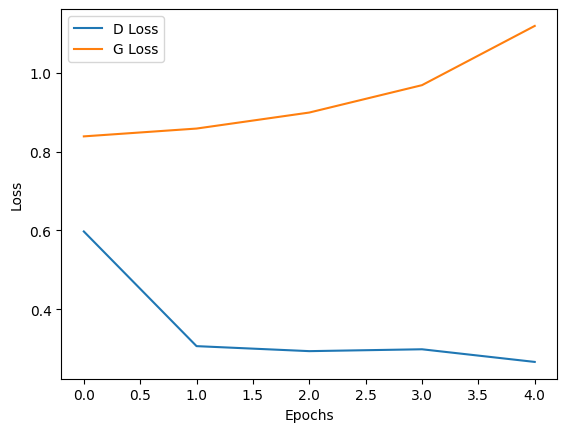

In [ ]:
import matplotlib.pyplot as plt
plt.plot(d_loss_arr, label='D Loss')
plt.plot(g_loss_arr, label='G Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 111ms/step


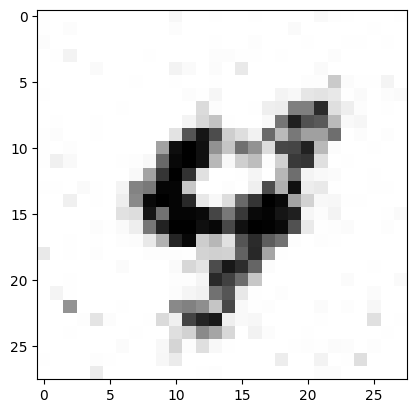

In [ ]:
#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('gen_model_test.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


